# Hyperparameter Optimization (HPO) of Machine Learning Models
L. Yang and A. Shami, “On hyperparameter optimization of machine learning algorithms: Theory and practice,” Neurocomputing, vol. 415, pp. 295–316, 2020, doi: https://doi.org/10.1016/j.neucom.2020.07.061.

### **Sample code for regression problems**  
**Dataset used:**  
&nbsp; Boson Housing dataset from sklearn

**Machine learning algorithms used:**  
&nbsp; Random forest (RF), support vector machine (SVM), k-nearest neighbor (KNN), artificial neural network (ANN)

**HPO algorithms used:**  
&nbsp; Grid search, random search, hyperband, Bayesian Optimization with Gaussian Processes (BO-GP), Bayesian Optimization with Tree-structured Parzen Estimator (BO-TPE), particle swarm optimization (PSO), genetic algorithm (GA).

**Performance metric:**  
&nbsp; Mean square error (MSE)

In [1]:
import os

def install_packages(packages):
    for package in packages:
        !pip install {package}

packages_to_install = [
    "tensorflow<2.11",
    "scikeras",
    "keras",
    "seaborn",
    "Optunity",
    "sklearn-deap",
    "colorama",
    "scikit-optimize",
    "hyperopt",
    "tpot",
    "ipykernel",
    "jupyter",
    "scikeras[tensorflow]",
    "scikeras[tensorflow-cpu]"
]

install_packages(packages_to_install)

/bin/bash: line 1: 2.11: No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72027 sha256=90b7d4220e6a6f93bfc3e4e0fa92e7d22b96b997fd470df3b66daca9d6a97883
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built Optunity
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 3.4 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=0828386572750303b5a5b3533f007f0cada7ee62530bb4a8b9ab6f9abdf4941a
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Succ

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import optunity
import optunity.metrics
import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from random import randrange as sp_randrange
from sklearn.neural_network import MLPRegressor
from skopt import Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, hp, tpe, STATUS_OK, space_eval
from scipy.stats import uniform


## Load Boston Housing dataset
We will take the Housing dataset which contains information about different houses in Boston. There are 506 samples and 13 feature variables in this Boston dataset. The main goal is to predict the value of prices of the house using the given features.

You can read more about the data and the variables [[1]](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [3]:
url = "https://faculty.tuck.dartmouth.edu/images/uploads/faculty/business-analytics/Boston_Housing.xlsx"
df = pd.read_excel(url)
print(df.head())
X = df.iloc[:,0:13].values  # Caratteristiche
y = df.iloc[:,13].values  # Target (MEDV is the Median value of owner-occupied homes in $1000's)
# Imposta l'opzione di stampa per visualizzare tutte le righe e colonne di numpy array
#np.set_printoptions(threshold=np.inf)
print("\n")
print("Features (X):")
print(X[:5]) #shows only the first 5 rows
print("\nTarget (y):")
print(y[:5]) #shows only the first 5 rows
df

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


Features (X):
[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [4]:
# #Applying Quality Checks techniques before applying Regression
# from pandas import read_csv
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import IsolationForest
# from sklearn.covariance import EllipticEnvelope
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.svm import OneClassSVM
# from sklearn.metrics import mean_absolute_error

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# print("X e y train prima di rimuovere gli outliers:")
# print(X_train.shape,y_train.shape,"\n")

# # fit the model
# model = LinearRegression()
# model.fit(X_train, y_train)
# # evaluate the model before removing ouliters
# outliers = model.predict(X_test)

# # evaluate predictions
# mae = mean_absolute_error(y_test, outliers)
# print('MAE: %.3f' % mae)

# #Isolation Forest
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(X_train)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]
# # summarize the shape of the updated training dataset
# print("X e y train dopo aver rimosso gli outliers:")
# print(X_train.shape,y_train.shape,"\n")
# print(X_train.shape, y_train.shape)

# # fit the model
# model = LinearRegression()
# model.fit(X_train, y_train)
# # evaluate the model
# yhat = model.predict(X_test)

# # evaluate predictions
# mae = mean_absolute_error(y_test, yhat)
# print('MAE: %.3f' % mae)

# #Nuovo dataset
# X= X_train
# y= y_train

## Baseline Machine Learning Models: Regressors with Default Hyperparameters

### Using 3-Fold Cross-Validation

### Defining the Artificial Neural Network

In [5]:
#ANN
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

def ANN(optimizer = 'adam',neurons=32,batch_size=32,epochs=50,activation='relu',patience=5,loss='mse'):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))  # Input layer with input shape (13 features)
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience = patience) # early stop patience
    history = model.fit(X, y,
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    return model

In [6]:
import tensorflow as tf

@tf.function(reduce_retracing =True)
def predict_with_model(model, X):
    return model.predict(X)

results = []

# 3-Fold Cross-Validation
# Random Forest
clf_rf = RandomForestRegressor()
start_time = time.time()
scores_rf = cross_val_score(clf_rf, X, y, cv=3, scoring='neg_mean_squared_error')
elapsed_time_rf = round(time.time() - start_time, 2)
results.append({'Algorithm': 'Random Forest', 'MSE': -scores_rf.mean(), 'Time Elapsed (s)': elapsed_time_rf})

# SVM
clf_svm = SVR()
start_time = time.time()
scores_svm = cross_val_score(clf_svm, X, y, cv=3, scoring='neg_mean_squared_error')  # 3-fold cross-validation
elapsed_time_svm = round(time.time() - start_time, 2)
results.append({'Algorithm': 'SVM', 'MSE': -scores_svm.mean(), 'Time Elapsed (s)': elapsed_time_svm})

# KNN
clf_knn = KNeighborsRegressor()
start_time = time.time()
scores_knn = cross_val_score(clf_knn, X, y, cv=3, scoring='neg_mean_squared_error')
elapsed_time_knn = round(time.time() - start_time, 2)
results.append({'Algorithm': 'KNN', 'MSE': -scores_knn.mean(), 'Time Elapsed (s)': elapsed_time_knn})

# ANN
start_time = time.time()
clf_ann = KerasRegressor(model=ANN, verbose=1)
scores_ann = cross_val_score(clf_ann, X, y, cv=3, scoring='neg_mean_squared_error')
elapsed_time_ann = round(time.time() - start_time, 2)

results.append({'Algorithm': 'ANN', 'MSE': -scores_ann.mean(), 'Time Elapsed (s)': elapsed_time_ann})

results_df_3_fold = pd.DataFrame(results)
print("Results for 3-Fold Cross-Validation ")
print(results_df_3_fold.to_string(index=False))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.4742
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37.1340
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.4907


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Results for 3-Fold Cross-Validation 
    Algorithm       MSE  Time Elapsed (s)
Random Forest 29.963987              3.82
          SVM 77.429518              0.08
          KNN 81.487732              0.04
          ANN 39.530172             40.42


## HPO Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [7]:
#Grid Search
#about 30 minutes to run
# Inizializza i dati per la tabella
results_grid_search = []

# Random Forest
rf_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [15, 20, 30, 50]
}
clf_rf = RandomForestRegressor(random_state=0)
start_time = time.time()
grid_rf = GridSearchCV(clf_rf, rf_params, cv=3, scoring='neg_mean_squared_error')
grid_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time, 2)
results_grid_search.append({'Algorithm': 'Random Forest', 'Best Params': grid_rf.best_params_, 'MSE': -grid_rf.best_score_, 'Time Elapsed (s)': elapsed_time_rf})

# SVM
svm_params = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'epsilon': [0.01, 0.1, 1]
}
clf_svm = SVR(gamma='scale')
start_time = time.time()
grid_svm = GridSearchCV(clf_svm, svm_params, cv=3, scoring='neg_mean_squared_error')
grid_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time, 2)
results_grid_search.append({'Algorithm': 'SVM', 'Best Params': grid_svm.best_params_, 'MSE': -grid_svm.best_score_, 'Time Elapsed (s)': elapsed_time_svm})

# KNN
knn_params = {
    'n_neighbors': [2, 3, 5, 7, 10]
}
clf_knn = KNeighborsRegressor()
start_time = time.time()
grid_knn = GridSearchCV(clf_knn, knn_params, cv=3, scoring='neg_mean_squared_error')
grid_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time, 2)
results_grid_search.append({'Algorithm': 'KNN', 'Best Params': grid_knn.best_params_, 'MSE': -grid_knn.best_score_, 'Time Elapsed (s)': elapsed_time_knn})

#ANN
from sklearn.model_selection import GridSearchCV
rf_params = {
    'optimizer': ['adam','rmsprop'],
    'activation': ['relu','tanh'],
    'loss': ['mse'],
    'batch_size': [16,32],
    'neurons':[16,32],
    'epochs':[20,50],
    'patience':[2,5]
}

start_time = time.time()
clf = KerasRegressor(model=ANN, activation='relu', neurons=16, patience=2, verbose=0)
grid_ann = GridSearchCV(clf, rf_params, cv=3, n_jobs=-1,scoring='neg_mean_squared_error')
grid_ann.fit(X, y)
elapsed_time_knn = round(time.time() - start_time, 2)
results_grid_search.append({'Algorithm': 'ANN', 'Best Params': grid_ann.best_params_, 'MSE': -grid_ann.best_score_, 'Time Elapsed (s)': elapsed_time_knn})
results_df_grid_search = pd.DataFrame(results_grid_search)

print("Results for Grid Search")
print(results_df_grid_search.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for Grid Search
    Algorithm                                                                                                              Best Params       MSE  Time Elapsed (s)
Random Forest                                                                                    {'max_depth': 30, 'n_estimators': 10} 28.068229              6.73
          SVM                                                                            {'C': 100, 'epsilon': 0.01, 'kernel': 'poly'} 67.076448              2.18
          KNN                                                                                                       {'n_neighbors': 5} 81.487732              0.05
          ANN {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'loss': 'mse', 'neurons': 32, 'optimizer': 'adam', 'patience': 5} 41.054292           1139.42


## HPO Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [8]:
from keras.layers import Input
from scipy.stats import uniform
# Inizializza i dati per la tabella
results_random_search = []

# Random Forest
rf_params = {
    'n_estimators': sp_randint(10, 100),
    'max_features': sp_randint(1, 13),
    'max_depth': sp_randint(5, 50),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'criterion': ['friedman_mse', 'poisson', 'squared_error', 'absolute_error']
}
n_iter_search = 20
clf_rf = RandomForestRegressor(random_state=0)
start_time = time.time()
Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params, n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
Random_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time, 2)
results_random_search.append({'Algorithm': 'Random Forest', 'Best Params': Random_rf.best_params_, 'MSE': -Random_rf.best_score_, 'Time Elapsed (s)': elapsed_time_rf})

# SVM
svm_params = {
    'C': uniform(0, 50),
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'epsilon': uniform(0, 1)
}
n_iter_search = 20
clf_svm = SVR(gamma='scale')
start_time = time.time()
Random_svm = RandomizedSearchCV(clf_svm, param_distributions=svm_params, n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
Random_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time, 2)
results_random_search.append({'Algorithm': 'SVM', 'Best Params': Random_svm.best_params_, 'MSE': -Random_svm.best_score_, 'Time Elapsed (s)': elapsed_time_svm})

# KNN
knn_params = {
    'n_neighbors': sp_randint(1, 20),
}
n_iter_search = 10
clf_knn = KNeighborsRegressor()
start_time = time.time()
Random_knn = RandomizedSearchCV(clf_knn, param_distributions=knn_params, n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
Random_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time, 2)
results_random_search.append({'Algorithm': 'KNN', 'Best Params': Random_knn.best_params_, 'MSE': -Random_knn.best_score_, 'Time Elapsed (s)': elapsed_time_knn})

def ANN(optimizer='adam', neurons=32, batch_size=32, epochs=50, activation='relu', patience=5, loss='mse'):
    input_layer = Input(shape=(X.shape[1],))
    model = Dense(neurons, activation=activation)(input_layer)
    model = Dense(neurons, activation=activation)(model)
    output_layer = Dense(1)(model)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    early_stopping = EarlyStopping(monitor="loss", patience=patience)
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], verbose=0)
    return model

ann_params = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'loss': ['mse'],
    'batch_size': [16, 32, 64],
    'neurons': sp_randint(10, 100),
    'epochs': [20, 50],
    'patience': sp_randint(3, 20)
}
n_iter_search = 10
clf_ann = KerasRegressor(model=ANN, activation='relu',neurons=93,patience=6,verbose=0)
Random_ann = RandomizedSearchCV(clf_ann, param_distributions=ann_params, n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
Random_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time, 2)
results_random_search.append({'Algorithm': 'ANN', 'Best Params': Random_ann.best_params_, 'MSE': -Random_ann.best_score_, 'Time Elapsed (s)': elapsed_time_ann})

# Creare un DataFrame pandas dalla lista dei risultati
results_df_random_search = pd.DataFrame(results_random_search)

print("Results for Random Search")
# Stampa il DataFrame senza l'indice
print(results_df_random_search.to_string(index=False))


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for Random Search
    Algorithm                                                                                                                            Best Params       MSE  Time Elapsed (s)
Random Forest {'criterion': 'squared_error', 'max_depth': 38, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 86} 27.092195              9.88
          SVM                                                             {'C': 28.819939151258417, 'epsilon': 0.8105729907806655, 'kernel': 'poly'} 60.842426              1.63
          KNN                                                                                                                    {'n_neighbors': 13} 80.741215              0.16
          ANN           {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'loss': 'mse', 'neurons': 59, 'optimizer': 'rmsprop', 'patience': 11} 42.463828            232.42


## HPO Algorithm 3: BO-GP
Bayesian Optimization with Gaussian Process (BO-GP)

**Advantages:**
* Fast convergence speed for continuous HPs.  

**Disadvantages:**  
* Poor capacity for parallelization.
* Not efficient with conditional HPs.

### Using skopt.BayesSearchCV

In [9]:
# Inizializza i dati per la tabella
results_bayes = []

# Random Forest
rf_params = {
    'n_estimators': Integer(10, 100),
    'max_features': Integer(1, 13),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 11),
    'min_samples_leaf': Integer(1, 11),
    'criterion': ['squared_error', 'friedman_mse', 'poisson']
}

clf_rf = RandomForestRegressor(random_state=0)
start_time_rf = time.time()
Bayes_rf = BayesSearchCV(clf_rf, rf_params, cv=3, n_iter=20, scoring='neg_mean_squared_error')
Bayes_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
results_bayes.append({'Algorithm': 'Random Forest', 'Best Params': Bayes_rf.best_params_, 'MSE': -Bayes_rf.best_score_, 'Time Elapsed (s)': elapsed_time_rf})

# SVM
svm_params = {
    'C': Real(0.1, 50),
    "kernel": ['poly', 'rbf', 'sigmoid'],
    'epsilon': Real(0, 1)
}

clf_svm = SVR(gamma='scale')
start_time_svm = time.time()
Bayes_svm = BayesSearchCV(clf_svm, svm_params, cv=3, n_iter=20, scoring='neg_mean_squared_error')
Bayes_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
results_bayes.append({'Algorithm': 'SVM', 'Best Params': Bayes_svm.best_params_, 'MSE': -Bayes_svm.best_score_, 'Time Elapsed (s)': elapsed_time_svm})

# KNN
knn_params = {
    'n_neighbors': Integer(1, 20),
}
clf_knn = KNeighborsRegressor()
start_time_knn = time.time()
Bayes_knn = BayesSearchCV(clf_knn, knn_params, cv=3, n_iter=10, scoring='neg_mean_squared_error')
Bayes_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
results_bayes.append({'Algorithm': 'KNN', 'Best Params': Bayes_knn.best_params_, 'MSE': -Bayes_knn.best_score_, 'Time Elapsed (s)': elapsed_time_knn})

# # Definisci la funzione per costruire il modello ANN
# def build_ann(optimizer='adam', activation='relu', neurons=32, patience=5, loss='mse'):
#     model = Sequential()
#     model.add(Dense(neurons, input_shape=(X.shape[1],), activation=activation))
#     model.add(Dense(neurons, activation=activation))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss=loss)
#     early_stopping = EarlyStopping(monitor="loss", patience=patience)
#     return model

# Definisci i parametri della ricerca
rf_params = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'loss': ['mse'],
    'batch_size': [16, 32, 64],
    'neurons': Integer(10, 100),
    'epochs': Categorical([20, 50]),
    'patience': Integer(3, 20)
}

# Inizializza KerasRegressor con la funzione di costruzione del modello
clf_ann = KerasRegressor(model=ANN, activation='relu',neurons=Integer(10, 100),patience=Integer(3, 20),verbose=0)

# Esegui la ricerca degli iperparametri
start_time = time.time()
Bayes = BayesSearchCV(clf_ann, rf_params, cv=3, n_iter=10, scoring='neg_mean_squared_error')
Bayes.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)
results_bayes.append({'Algorithm': 'ANN', 'Best Params': Bayes.best_params_, 'MSE': -Bayes.best_score_, 'Time Elapsed (s)': elapsed_time})

# Creare un DataFrame pandas dalla lista dei risultati
results_bayes_df = pd.DataFrame(results_bayes)

print("Results for Bayesian Optimization with Gaussian Process")
print(results_bayes_df.to_string(index=False))

Results for Bayesian Optimization with Gaussian Process
    Algorithm                                                                                                                           Best Params       MSE  Time Elapsed (s)
Random Forest {'criterion': 'friedman_mse', 'max_depth': 33, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 26.596340             37.82
          SVM                                                                           {'C': 32.951983099755495, 'epsilon': 1.0, 'kernel': 'poly'} 59.836698             22.35
          KNN                                                                                                                   {'n_neighbors': 13} 80.741215              1.10
          ANN             {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'loss': 'mse', 'neurons': 56, 'optimizer': 'adam', 'patience': 12} 41.979751            250.73


### Using skopt.gp_minimize

In [10]:
from keras.layers import Input
from scipy.stats import uniform
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

results_skopt_gp_minimize = []

# Random Forest
reg = RandomForestRegressor()
# Define the hyperparameter configuration space
space  = [Integer(10, 100, name='n_estimators'),
          Integer(5, 50, name='max_depth'),
          Integer(1, 13, name='max_features'),
          Integer(2, 11, name='min_samples_split'),
          Integer(1, 11, name='min_samples_leaf'),
         Categorical(['friedman_mse'], name='criterion')
         ]
# Define the objective function
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)
    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

start_time = time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
#random_search.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)
results_skopt_gp_minimize.append({'Algorithm': 'Random Forest', 'Best Params': res_gp.x, 'MSE': res_gp.fun, 'Time Elapsed (s)': elapsed_time})

#SVM
reg = SVR(gamma='scale')
space  = [Real(1, 50, name='C'),
          Categorical(['poly','rbf','sigmoid'], name='kernel'),
          Real(0, 1, name='epsilon')
         ]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))
start_time = time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
elapsed_time = round(time.time() - start_time, 2)
results_skopt_gp_minimize.append({'Algorithm': 'SVM', 'Best Params': res_gp.x, 'MSE': res_gp.fun, 'Time Elapsed (s)': elapsed_time})

#KNN
reg = KNeighborsRegressor()
space  = [Integer(1, 20, name='n_neighbors')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

start_time = time.time()
res_gp = gp_minimize(objective, space, n_calls=10, random_state=0)
elapsed_time = round(time.time() - start_time, 2)
results_skopt_gp_minimize.append({'Algorithm': 'KNN', 'Best Params': res_gp.x, 'MSE': res_gp.fun, 'Time Elapsed (s)': elapsed_time})

# Define the function to build the neural network model
def build_ann(optimizer='adam', activation='relu', neurons=32, patience=5, loss='mse'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience=patience)
    return model

# Define the hyperparameter configuration space
space  = [Categorical(['adam', 'rmsprop'], name='optimizer'),
          Categorical(['relu', 'tanh'], name='activation'),
          Integer(10, 100, name='neurons'),
          Integer(3, 20, name='patience'),
          Categorical(['mse'], name='loss')
         ]

# Define the objective function
@use_named_args(space)
def objective(**params):
    # Wrap the Keras model into a scikit-learn estimator
    clf = KerasRegressor(build_fn=build_ann, **params)
    # Compute the negative mean squared error using cross-validation
    mse = -np.mean(cross_val_score(clf, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))
    return mse

# Perform optimization
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
results_skopt_gp_minimize.append({'Algorithm': 'ANN', 'Best Params': res_gp.x, 'MSE': res_gp.fun, 'Time Elapsed (s)': elapsed_time})

results_df_skopt_gp_minimize_df = pd.DataFrame(results_skopt_gp_minimize)
print("Results for skopt.gp_minimize")
print(results_df_skopt_gp_minimize_df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['rmsprop', 'tanh', 100, 20, 'mse'] before, using random point ['rmsprop', 'tanh', 61, 5, 'mse']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['rmsprop', 'tanh', 100, 3, 'mse'] before, using random point ['adam', 'tanh', 89, 12, 'mse']
  warnings.warn(


Results for skopt.gp_minimize
    Algorithm                      Best Params        MSE  Time Elapsed (s)
Random Forest [100, 18, 5, 2, 1, friedman_mse]  26.442738             18.14
          SVM   [44.48429723956441, poly, 0.0]  58.514420              6.47
          KNN                             [13]  80.741215              0.69
          ANN     [rmsprop, tanh, 100, 3, mse] 319.574304              0.69


## HPO Algorithm 4: BO-TPE
Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

**Advantages:**
* Efficient with all types of HPs.
* Keep conditional dependencies.

**Disadvantages:**  
* Poor capacity for parallelization.

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Bayesian Optimization with Tree-structured Parzen Estimator (TPE)
results_bo_tpe = []

# Random Forest
def objective_rf(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split": int(params['min_samples_split']),
        "min_samples_leaf": int(params['min_samples_leaf']),
        "criterion": str(params['criterion'])
    }
    clf = RandomForestRegressor(**params)
    start_time = time.time()
    loss = -np.mean(cross_val_score(clf, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return {'loss': loss,'status': STATUS_OK}

space_rf = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features": hp.quniform('max_features', 1, 13, 1),
    "min_samples_split": hp.quniform('min_samples_split', 2, 11, 1),
    "min_samples_leaf": hp.quniform('min_samples_leaf', 1, 11, 1),
    "criterion": hp.choice('criterion', ['friedman_mse'])
}

best_rf = fmin(fn=objective_rf, space=space_rf, algo=tpe.suggest, max_evals=20)
elapsed_time_rf = round(time.time() - start_time, 2)
best_params_rf = space_eval(space_rf, best_rf)

results_bo_tpe.append({'Algorithm': 'Random Forest', 'Best Params': best_params_rf, 'MSE': objective_rf(best_params_rf)['loss'], 'Time Elapsed (s)': elapsed_time_rf})

# SVM
def objective_svm(params):
    params = {
        'C': abs(float(params['C'])),
        "kernel": str(params['kernel']),
        'epsilon': abs(float(params['epsilon'])),
    }
    clf = SVR(gamma='scale', **params)
    start_time = time.time()
    loss = -np.mean(cross_val_score(clf, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return {'loss': loss, 'status': STATUS_OK}

space_svm = {
    'C': hp.normal('C', 0, 50),
    "kernel": hp.choice('kernel', ['poly', 'rbf', 'sigmoid']),
    'epsilon': hp.normal('epsilon', 0, 1),
}

best_svm = fmin(fn=objective_svm, space=space_svm, algo=tpe.suggest, max_evals=20)
elapsed_time_svm = round(time.time() - start_time, 2)
best_params_svm = space_eval(space_svm, best_svm)

results_bo_tpe.append({'Algorithm': 'SVM', 'Best Params': best_svm, 'MSE': objective_svm(best_params_svm)['loss'], 'Time Elapsed (s)': elapsed_time_svm})

# KNN
def objective_knn(params):
    params = {
        'n_neighbors': abs(int(params['n_neighbors']))
    }
    clf = KNeighborsRegressor(**params)
    start_time = time.time()
    loss = -np.mean(cross_val_score(clf, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return {'loss': loss, 'MSE': loss, 'status': STATUS_OK}

space_knn = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),
}

best_knn = fmin(fn=objective_knn, space=space_knn, algo=tpe.suggest, max_evals=20)
elapsed_time_knn = round(time.time() - start_time, 2)
best_params_knn = space_eval(space_knn, best_knn)
results_bo_tpe.append({'Algorithm': 'KNN', 'Best Params': best_knn, 'MSE': objective_knn(best_params_knn)['loss'], 'Time Elapsed (s)': elapsed_time_knn})

# ANN
def objective_ann(params):
    params = {
        "optimizer": str(params['optimizer']),
        "activation": str(params['activation']),
        "loss": str(params['loss']),
        'batch_size': abs(int(params['batch_size'])),
        'neurons': abs(int(params['neurons'])),
        'epochs': abs(int(params['epochs'])),
        'patience': abs(int(params['patience']))
    }
    clf = KerasRegressor(model=ANN, **params, verbose=0)
    start_time = time.time()
    loss = -np.mean(cross_val_score(clf, X, y, cv=3, scoring="neg_mean_squared_error"))
    return {'loss': loss, 'MSE': loss, 'status': STATUS_OK}

space_ann = {
    "optimizer": hp.choice('optimizer', ['adam', 'rmsprop']),
    "activation": hp.choice('activation', ['relu', 'tanh']),
    "loss": hp.choice('loss', ['mse']),
    'batch_size': hp.quniform('batch_size', 16, 64, 16),
    'neurons': hp.quniform('neurons', 10, 100, 10),
    'epochs': hp.quniform('epochs', 20, 50, 10),
    'patience': hp.quniform('patience', 3, 20, 3),
}

best_ann = fmin(fn=objective_ann, space=space_ann, algo=tpe.suggest, max_evals=20)
elapsed_time_ann = round(time.time() - start_time, 2)
best_params_ann = space_eval(space_ann, best_ann)
results_bo_tpe.append({'Algorithm': 'ANN', 'Best Params': best_ann, 'MSE': objective_ann(best_params_ann)['loss'], 'Time Elapsed (s)': elapsed_time_ann})

# Creazione del DataFrame dei risultati
results_df_bo_tpe = pd.DataFrame(results_bo_tpe)

# Stampa della tabella dei risultati
print("Results for Bayesian Optimization with Tree-structured Parzen Estimator")
print(results_df_bo_tpe.to_string(index=False))


100%|██████████| 20/20 [07:16<00:00, 21.80s/trial, best loss: 42.184231893673264]
Results for Bayesian Optimization with Tree-structured Parzen Estimator
    Algorithm                                                                                                                                    Best Params       MSE  Time Elapsed (s)
Random Forest {'criterion': 'friedman_mse', 'max_depth': 28.0, 'max_features': 4.0, 'min_samples_leaf': 6.0, 'min_samples_split': 5.0, 'n_estimators': 43.0} 28.504919            115.39
          SVM                                                                          {'C': 42.371431790604845, 'epsilon': 0.0302507459080146, 'kernel': 0} 58.329702            116.77
          KNN                                                                                                                           {'n_neighbors': 6.0} 80.830052            117.45
          ANN                            {'activation': 1, 'batch_size': 64.0, 'epochs': 30.0, 'loss': 0, 

## HPO Algorithm 5: PSO
Particle swarm optimization (PSO): Each particle in a swarm communicates with other particles to detect and update the current global optimum in each iteration until the final optimum is detected.

**Advantages:**
* Efficient with all types of HPs.
* Enable parallelization.

**Disadvantages:**  
* Require proper initialization.

In [12]:
#Results for Partical swarm optimization (PSO)
results_PSO = []

# Random Forest
search_rf = {
    'n_estimators': [10, 100],
    'max_features': [1, 13],
    'max_depth': [5, 50],
    "min_samples_split": [2, 11],
    "min_samples_leaf": [1, 11],
}

start_time = time.time()
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance_rf(x_train, y_train, x_test, y_test, n_estimators=None, max_features=None, max_depth=None, min_samples_split=None, min_samples_leaf=None):
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf))

    mse = -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return mse


optimal_configuration_rf, info_rf, _ = optunity.minimize(performance_rf,
                                                          solver_name='particle swarm',
                                                          num_evals=20,
                                                          **search_rf)
elapsed_time_rf = round(time.time() - start_time, 2)
results_PSO.append({'Algorithm': 'Random Forest', 'Best Params': optimal_configuration_rf, 'MSE': info_rf.optimum, 'Time Elapsed (s)': elapsed_time_rf})

# SVM
search_svm = {
    'C': (0, 50),
    'kernel': [0, 3],
    'epsilon': (0, 1)
}

start_time = time.time()
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance_svm(x_train, y_train, x_test, y_test, C=None, kernel=None, epsilon=None):
    if kernel < 1:
        ke = 'poly'
    elif kernel < 2:
        ke = 'rbf'
    else:
        ke = 'sigmoid'
    model = SVR(C=float(C), kernel=ke, gamma='scale', epsilon=float(epsilon))
    mse = -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return mse

optimal_configuration_svm, info_svm, _ = optunity.minimize(performance_svm,
                                                            solver_name='particle swarm',
                                                            num_evals=20,
                                                            **search_svm)
elapsed_time_svm = round(time.time() - start_time, 2)
results_PSO.append({'Algorithm': 'SVM', 'Best Params': optimal_configuration_svm, 'MSE': info_svm.optimum, 'Time Elapsed (s)': elapsed_time_svm})

# KNN
search_knn = {
    'n_neighbors': [1, 20],
}

start_time = time.time()
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance_knn(x_train, y_train, x_test, y_test, n_neighbors=None):
    model = KNeighborsRegressor(n_neighbors=int(n_neighbors))
    mse = -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring="neg_mean_squared_error"))
    return mse

optimal_configuration_knn, info_knn, _ = optunity.minimize(performance_knn,
                                                            solver_name='particle swarm',
                                                            num_evals=10,
                                                            **search_knn)
elapsed_time_knn = round(time.time() - start_time,  2)
results_PSO.append({'Algorithm': 'KNN', 'Best Params': optimal_configuration_knn, 'MSE': info_knn.optimum, 'Time Elapsed (s)': elapsed_time_knn})

#ANN
search_ann = {
    'optimizer':[0,2],
    'activation':[0,2],
    'loss':[0,2],
    'batch_size': [0, 2],
    'neurons': [10, 100],
    'epochs': [20, 50],
    'patience': [3, 20],
         }
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance_ann(x_train, y_train, x_test, y_test,optimizer=None,activation=None,loss=None,batch_size=None,neurons=None,epochs=None,patience=None):
    # fit the model
    if optimizer<1:
        op='adam'
    else:
        op='rmsprop'
    if activation<1:
        ac='relu'
    else:
        ac='tanh'
    if loss<1:
        lo='mse'
    else:
        lo='mae'
    if batch_size<1:
        ba=16
    else:
        ba=32
    model = ANN(optimizer=op,
                activation=ac,
                loss=lo,
                batch_size=ba,
                neurons=int(neurons),
                epochs=int(epochs),
                patience=int(patience)
                                  )
    clf = KerasRegressor(model=ANN, verbose=0)
    scores=-np.mean(cross_val_score(clf, X, y, cv=3,
                                    scoring="neg_mean_squared_error"))

    return scores


optimal_configuration_ann, info_ann, _ = optunity.minimize(performance_ann,
                                                            solver_name='particle swarm',
                                                            num_evals=20,
                                                            **search_ann)
elapsed_time_ann = round(time.time() - start_time, 2)



results_PSO.append({'Algorithm': 'ANN', 'Best Params': optimal_configuration_ann, 'MSE': info_ann.optimum, 'Time Elapsed (s)': elapsed_time_ann})
results_df_PSO = pd.DataFrame(results_PSO)

print("Results for Particle Swarm Optimization")
print(results_df_PSO.to_string(index=True))


Results for Particle Swarm Optimization
       Algorithm                                                                                                                                                                                                                   Best Params        MSE  Time Elapsed (s)
0  Random Forest                                                               {'n_estimators': 86.0693359375, 'max_features': 5.142578125, 'max_depth': 40.61767578125, 'min_samples_split': 7.04931640625, 'min_samples_leaf': 1.8056640625}  27.032005             18.49
1            SVM                                                                                                                                                       {'C': 29.1748046875, 'kernel': 0.41455078125, 'epsilon': 0.35009765625}  60.531224              3.60
2            KNN                                                                                                                                            

### Using TPOT

In [21]:
import time
import warnings
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=RuntimeWarning)

results_TPOT = []

# Random Forest
parameters_rf = {
    'n_estimators': range(20, 200),
    "max_features": range(1, 13),
    'max_depth': range(10, 100),
    "min_samples_split": range(2, 11),
    "min_samples_leaf": range(1, 11),
}

start_time = time.time()
ga1 = TPOTRegressor(
    generations=3,
    population_size=10,
    offspring_size=5,
    verbosity=3,
    early_stop=5,
    config_dict={'sklearn.ensemble.RandomForestRegressor': parameters_rf},
    cv=3,
    scoring='neg_mean_squared_error'
)
ga1.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)

# Calcolo di MSE e R^2
y_pred_rf = ga1.predict(X)
mse_rf = -ga1.score(X, y)
r2_rf = r2_score(y, y_pred_rf)

results_TPOT.append({'Algorithm': 'Random Forest',
                     'Best Params': ga1.fitted_pipeline_.steps[0][1].get_params(),
                     'MSE': mse_rf,
                     'R²': r2_rf,
                     'Time Elapsed (s)': elapsed_time})

# SVM
parameters_svm = {
    'C': np.random.uniform(0, 50, 1000),
    "kernel": ['poly', 'rbf', 'sigmoid'],
    'epsilon': np.random.uniform(0, 1, 100),
    'gamma': ['scale']
}

start_time = time.time()
ga2 = TPOTRegressor(
    generations=3,
    population_size=10,
    offspring_size=5,
    verbosity=3,
    early_stop=5,
    config_dict={'sklearn.svm.SVR': parameters_svm},
    cv=3,
    scoring='neg_mean_squared_error'
)
ga2.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)

# Calcolo di MSE e R^2
y_pred_svm = ga2.predict(X)
mse_svm = -ga2.score(X, y)
r2_svm = r2_score(y, y_pred_svm)

results_TPOT.append({'Algorithm': 'SVM',
                     'Best Params': ga2.fitted_pipeline_.steps[0][1].get_params(),
                     'MSE': mse_svm,
                     'R²': r2_svm,
                     'Time Elapsed (s)': elapsed_time})

# KNN
parameters_knn = {
    'n_neighbors': range(1, 20),
}

start_time = time.time()
ga3 = TPOTRegressor(
    generations=3,
    population_size=10,
    offspring_size=5,
    verbosity=3,
    early_stop=5,
    config_dict={'sklearn.neighbors.KNeighborsRegressor': parameters_knn},
    cv=3,
    scoring='neg_mean_squared_error'
)
ga3.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)

# Calcolo di MSE e R^2
y_pred_knn = ga3.predict(X)
mse_knn = -ga3.score(X, y)
r2_knn = r2_score(y, y_pred_knn)

results_TPOT.append({'Algorithm': 'KNN',
                     'Best Params': ga3.fitted_pipeline_.steps[0][1].get_params(),
                     'MSE': mse_knn,
                     'R²': r2_knn,
                     'Time Elapsed (s)': elapsed_time})

# ANN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nn_parameters = {
    'sklearn.neural_network.MLPRegressor': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    }
}

start_time = time.time()
tpot_nn = TPOTRegressor(
    generations=3,
    population_size=10,
    offspring_size=5,
    verbosity=2,
    early_stop=5,
    config_dict=nn_parameters,
    cv=3,
    scoring='neg_mean_squared_error'
)
tpot_nn.fit(X_train, y_train)
elapsed_time = round(time.time() - start_time, 2)

# Calcolo di MSE e R^2
y_pred_nn = tpot_nn.predict(X_test)
mse_nn = -tpot_nn.score(X_test, y_test)
r2_nn = r2_score(y_test, y_pred_nn)

results_TPOT.append({'Algorithm': 'ANN',
                     'Best Params': tpot_nn.fitted_pipeline_.steps[0][1].get_params(),
                     'MSE': mse_nn,
                     'R²': r2_nn,
                     'Time Elapsed (s)': elapsed_time})

# Creazione del DataFrame finale
results_df_TPOT = pd.DataFrame(results_TPOT)

# Visualizzazione dei risultati
print("Results for TPOT")
print(results_df_TPOT.to_string(index=False))

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-27.580820966761436	RandomForestRegressor(CombineDFs(input_matrix, input_matrix), RandomForestRegressor__max_depth=96, RandomForestRegressor__max_features=5, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=79)

-2	-25.510525916876713	RandomForestRegressor(RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=39, RandomForestRegressor__max_features=5, RandomForestRegressor__min_samples_leaf=9, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=172), RandomForestRegressor__max_depth=61, RandomForestRegressor__max_features=3, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=9, RandomForestRegressor__n_estimators=91)

Generation 2 - Current Pareto front scores:

-1	-26.602324876089966	RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=48, RandomForestRegressor__max_feature

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-60.10539315620596	SVR(CombineDFs(input_matrix, input_matrix), SVR__C=48.45827026039149, SVR__epsilon=0.17036653033003424, SVR__gamma=scale, SVR__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	-60.105393156204194	SVR(input_matrix, SVR__C=48.45827026039149, SVR__epsilon=0.17036653033003424, SVR__gamma=scale, SVR__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	-60.105393156204194	SVR(input_matrix, SVR__C=48.45827026039149, SVR__epsilon=0.17036653033003424, SVR__gamma=scale, SVR__kernel=poly)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-80.74121499347262	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=13)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	-80.74121499347262	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=13)

Generation 3 - Current Pareto front scores:

-1	-80.74121499347262	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=13)


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -30.95027401103637

Generation 2 - Current best internal CV score: -29.34371767113296

Generation 3 - Current best internal CV score: -29.34371767113296

Best pipeline: MLPRegressor(input_matrix, activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, solver=lbfgs)
Results for TPOT
    Algorithm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [22]:
import pandas as pd

# Lista dei DataFrame dei risultati e relativi percorsi per il salvataggio
results_dataframes = [
    (results_df_3_fold, '/content/results_3_fold.csv'),
    (results_df_grid_search, '/content/results_grid_search.csv'),
    (results_df_random_search, '/content/results_random_search.csv'),
    (results_bayes_df, '/content/results_bayes.csv'),
    (results_df_skopt_gp_minimize_df, '/content/results_skopt.csv'),
    (results_df_bo_tpe, '/content/results_bo_tpe.csv'),
    (results_df_PSO, '/content/results_PSO.csv'),
    (results_df_TPOT, '/content/results_TPOT.csv'),
]

# Salvataggio dei risultati in file CSV
for results_df, file_path in results_dataframes:
    results_df.to_csv(file_path, index=False)

In [23]:
import os

def install_packages(packages):
    for package in packages:
        !pip install {package}

packages_to_install = [
    "pdfpages",
    "reportlab",
    "hpbandster",
    "hpbandster-sklearn",
    "tabulate"
]

# Rimuovi scikit-learn in modo silenzioso
!pip uninstall scikit-learn -y -q
packages_to_install.append("scikit-learn==1.0.2")

install_packages(packages_to_install)

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 0.12.2 requires scikit-learn>=1.4.1, but you have scikit-learn 1.0.2 which is incompatible.
bigframes 1.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.2 requires scik

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import optunity
import optunity.metrics
import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from random import randrange as sp_randrange
from sklearn.neural_network import MLPRegressor
from skopt import Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, hp, tpe, STATUS_OK, space_eval
from scipy.stats import uniform

In [4]:
url = "https://faculty.tuck.dartmouth.edu/images/uploads/faculty/business-analytics/Boston_Housing.xlsx"
df = pd.read_excel(url)
print(df.head())
X = df.iloc[:,0:13].values  # Caratteristiche
y = df.iloc[:,13].values  # Target (MEDV is the Median value of owner-occupied homes in $1000's)
# Imposta l'opzione di stampa per visualizzare tutte le righe e colonne di numpy array
#np.set_printoptions(threshold=np.inf)
print("\n")
print("Features (X):")
print(X[:5]) #shows only the first 5 rows
print("\nTarget (y):")
print(y[:5]) #shows only the first 5 rows
df

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


Features (X):
[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [26]:
# #Applying Quality Checks techniques before applying Regression
# from pandas import read_csv
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import IsolationForest
# from sklearn.covariance import EllipticEnvelope
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.svm import OneClassSVM
# from sklearn.metrics import mean_absolute_error

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# print("X e y train prima di rimuovere gli outliers:")
# print(X_train.shape,y_train.shape,"\n")

# # fit the model
# model = LinearRegression()
# model.fit(X_train, y_train)
# # evaluate the model before removing ouliters
# outliers = model.predict(X_test)

# # evaluate predictions
# mae = mean_absolute_error(y_test, outliers)
# print('MAE: %.3f' % mae)

# #Isolation Forest
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(X_train)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]
# # summarize the shape of the updated training dataset
# print("X e y train dopo aver rimosso gli outliers:")
# print(X_train.shape,y_train.shape,"\n")
# print(X_train.shape, y_train.shape)

# # fit the model
# model = LinearRegression()
# model.fit(X_train, y_train)
# # evaluate the model
# yhat = model.predict(X_test)

# # evaluate predictions
# mae = mean_absolute_error(y_test, yhat)
# print('MAE: %.3f' % mae)

# #Nuovo dataset
# X= X_train
# y= y_train

## HPO Algorithm 6: Hyperband
Generate small-sized subsets and allocate budgets to each hyper-parameter combination based on its performance

**Advantages:**
* Enable parallelization.  

**Disadvantages:**  
* Not efficient with conditional HPs.
* Require subsets with small budgets to be representative.

In [5]:
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint as sp_randint
import time


warnings.filterwarnings('ignore')

# Assuming X and y are your feature matrix and target vector
# If they're not defined, you need to define them before this code

results_hyperband = []

# Random Forest
rf_params = {
    'max_features': sp_randint(1, X.shape[1] + 1),
    'max_depth': sp_randint(5, 50),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'criterion': ['friedman_mse']
}
clf_rf = RandomForestRegressor(random_state=0)
start_time = time.time()
Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params, n_iter=100, scoring='neg_mean_squared_error', random_state=0)
Random_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time, 2)

# Calcolo di R² per Random Forest
best_rf = Random_rf.best_estimator_
y_pred_rf = best_rf.predict(X)
r2_rf = r2_score(y, y_pred_rf)

results_hyperband.append({'Algorithm': 'Random Forest', 'Best Params': Random_rf.best_params_, 'MSE': -Random_rf.best_score_, 'R²': r2_rf, 'Time Elapsed (s)': elapsed_time_rf})

# SVM
svm_params = {
    'C': uniform(0, 1),
    'kernel': ['sigmoid', 'rbf', 'poly'],
    'gamma': ['scale']
}
svm_estimator = SVR(gamma='scale')
start_time = time.time()
Random_svm = RandomizedSearchCV(svm_estimator, svm_params, n_iter=100, scoring='neg_mean_squared_error', random_state=0)
Random_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time, 2)

# Calcolo di R² per SVM
best_svm = Random_svm.best_estimator_
y_pred_svm = best_svm.predict(X)
r2_svm = r2_score(y, y_pred_svm)

results_hyperband.append({'Algorithm': 'SVM', 'Best Params': Random_svm.best_params_, 'MSE': -Random_svm.best_score_, 'R²': r2_svm, 'Time Elapsed (s)': elapsed_time_svm})

# KNN
knn_params = {
    'n_neighbors': sp_randint(1, 20),
}
clf_knn = KNeighborsRegressor()
start_time = time.time()
Random_knn = RandomizedSearchCV(clf_knn, param_distributions=knn_params, n_iter=100, scoring='neg_mean_squared_error', random_state=0)
Random_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time, 2)

# Calcolo di R² per KNN
best_knn = Random_knn.best_estimator_
y_pred_knn = best_knn.predict(X)
r2_knn = r2_score(y, y_pred_knn)

results_hyperband.append({'Algorithm': 'KNN', 'Best Params': Random_knn.best_params_, 'MSE': -Random_knn.best_score_, 'R²': r2_knn, 'Time Elapsed (s)': elapsed_time_knn})

# ANN
ann_params = {
    'hidden_layer_sizes': [(sp_randint(10, 100).rvs(),) for _ in range(3)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': uniform(1e-6, 1),
    'batch_size': [16, 32, 64],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': uniform(1e-3, 1),
    'max_iter': [50, 100],
    'early_stopping': [True],
    'validation_fraction': [0.1]
}
ann_estimator = MLPRegressor()
start_time = time.time()
Random_ann = RandomizedSearchCV(ann_estimator, param_distributions=ann_params, n_iter=100, scoring='neg_mean_squared_error', random_state=0)
Random_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time, 2)

# Calcolo di R² per ANN
best_ann = Random_ann.best_estimator_
y_pred_ann = best_ann.predict(X)
r2_ann = r2_score(y, y_pred_ann)

results_hyperband.append({'Algorithm': 'ANN', 'Best Params': Random_ann.best_params_, 'MSE': -Random_ann.best_score_, 'R²': r2_ann, 'Time Elapsed (s)': elapsed_time_ann})

results_df_hyperband = pd.DataFrame(results_hyperband)

print("Results for Hyperband")
print(results_df_hyperband.to_string(index=False))

Results for Hyperband
    Algorithm                                                                                                                                                                                                                                                        Best Params       MSE       R²  Time Elapsed (s)
Random Forest                                                                                                                                                   {'criterion': 'friedman_mse', 'max_depth': 47, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2} 19.014210 0.984259            109.66
          SVM                                                                                                                                                                                                       {'C': 0.9495710534507421, 'gamma': 'scale', 'kernel': 'rbf'} 71.921277 0.207149              9.24
          KNN                                   

## HPO Algorithm 7: Genetic Algorithm
Genetic algorithms detect well-performing hyper-parameter combinations in each generation, and pass them to the next generation until the best-performing combination is identified.

**Advantages:**
* Efficient with all types of HPs.
* Not require good initialization.


**Disadvantages:**  
* Poor capacity for parallelization.

### Using DEAP

In [6]:
#Results for Genetic Algorithm
import warnings
from evolutionary_search import EvolutionaryAlgorithmSearchCV #lo trova solo con scikit learn 1.0.2
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential, load_model
import time
import tensorflow as tf
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_GA = []

# Definisci la funzione TensorFlow all'esterno del ciclo
@tf.function(experimental_relax_shapes=True)
def predict_with_model(model, X):
    return model.predict(X)

#Random Forest
rf_params = {
    'n_estimators': range(10,100),
    'max_features': range(1,13),
    'max_depth': range(5,50),
    'min_samples_split': range(2,11),
    'min_samples_leaf': range(1,11),
    'criterion': ['squared_error']
}

clf = RandomForestRegressor(random_state=0)
start_time = time.time()

# Esecuzione della ricerca degli iperparametri con GA
ga1 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                    params=rf_params,
                                    scoring="neg_mean_squared_error",
                                    cv=3,
                                    verbose=0,
                                    population_size=10,
                                    gene_mutation_prob=0.10,
                                    gene_crossover_prob=0.5,
                                    tournament_size=3,
                                    generations_number=5,
                                    n_jobs=1)

ga1.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)
results_GA.append({'Algorithm': 'Random Forest', 'Best Params': ga1.best_params_, 'MSE': -ga1.best_score_, 'Time Elapsed (s)': elapsed_time})

# SVM
svm_params = {
    'C': np.random.uniform(0,50,1000),
    'kernel': ['poly','rbf','sigmoid'],
    'epsilon': np.random.uniform(0,1,100),
}
clf = SVR(gamma='scale')
start_time = time.time()
ga2 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                    params=svm_params,
                                    scoring="neg_mean_squared_error",
                                    cv=3,
                                    verbose=0,
                                    population_size=10,
                                    gene_mutation_prob=0.10,
                                    gene_crossover_prob=0.5,
                                    tournament_size=3,
                                    generations_number=5,
                                    n_jobs=1)
ga2.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)
results_GA.append({'Algorithm': 'SVM', 'Best Params': ga2.best_params_, 'MSE': -ga2.best_score_, 'Time Elapsed (s)': elapsed_time})

# KNN
knn_params = {
    'n_neighbors': range(1,20),
}
clf = KNeighborsRegressor()
start_time = time.time()
ga3 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                    params=knn_params,
                                    scoring="neg_mean_squared_error",
                                    cv=3,
                                    verbose=0,
                                    population_size=10,
                                    gene_mutation_prob=0.10,
                                    gene_crossover_prob=0.5,
                                    tournament_size=3,
                                    generations_number=5,
                                    n_jobs=1)
ga3.fit(X, y)
elapsed_time = round(time.time() - start_time, 2)
results_GA.append({'Algorithm': 'KNN', 'Best Params': ga3.best_params_, 'MSE': -ga3.best_score_, 'Time Elapsed (s)': elapsed_time})

#ANN
def ANN(optimizer='adam', neurons=32, batch_size=32, epochs=50, activation='relu', patience=5, loss='mse'):
    input_layer = Input(shape=(X.shape[1],))
    model = Dense(neurons, activation=activation)(input_layer)
    model = Dense(neurons, activation=activation)(model)
    output_layer = Dense(1)(model)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    early_stopping = EarlyStopping(monitor="loss", patience=patience)  # early stop patience
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], verbose=0)
    return model

from evolutionary_search import EvolutionaryAlgorithmSearchCV
# Define the hyperparameter configuration space
rf_params_ann = {
    'optimizer': ['adam','rmsprop'],
    'activation': ['relu','tanh'],
    'loss': ['mse'],
    'batch_size': [16,32,64],
    'neurons':range(10,100),
    'epochs':[20,50],
    #'epochs':[20,50,100,200],
    'patience':range(3,20)
}

start_time = time.time()
clf_ann = KerasRegressor(model=ANN, activation='relu', neurons=Integer(10, 100), epochs=Integer(20, 50), patience=Integer(3, 20), loss='mse', batch_size=16, verbose=0)
# Set the hyperparameters of GA
ga4 = EvolutionaryAlgorithmSearchCV(estimator=clf_ann,
                                   params=rf_params_ann,
                                   scoring="neg_mean_squared_error",
                                   cv=3,
                                   verbose=0, #change to 1 to see details
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
ga4.fit(X, y)
print(ga4.best_params_)
print("MSE:"+ str(-ga4.best_score_))
elapsed_time = round(time.time() - start_time, 2)
results_GA.append({'Algorithm': 'ANN', 'Best Params': ga4.best_params_, 'MSE': -ga4.best_score_, 'Time Elapsed (s)': elapsed_time})

results_df_GA = pd.DataFrame(results_GA)
print("Results for Genetic Algorithm")
print(results_df_GA.to_string(index=False))

{'optimizer': 'rmsprop', 'activation': 'tanh', 'loss': 'mse', 'batch_size': 32, 'neurons': 89, 'epochs': 20, 'patience': 9}
MSE:35.13458206592042
Results for Genetic Algorithm
    Algorithm                                                                                                                            Best Params       MSE  Time Elapsed (s)
Random Forest {'n_estimators': 32, 'max_features': 10, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'} 26.890393              9.61
          SVM                                                            {'C': 43.128494166062254, 'kernel': 'poly', 'epsilon': 0.16397696389231453} 59.460911              0.87
          KNN                                                                                                                     {'n_neighbors': 5} 81.529335              0.06
          ANN            {'optimizer': 'rmsprop', 'activation': 'tanh', 'loss': 'mse', 'batch_size': 32, 'neurons': 

In [7]:
# Lista dei DataFrame dei risultati e relativi percorsi per il salvataggio
results_dataframes = [
    (results_df_GA, '/content/results_GA.csv'),
    (results_df_hyperband, '/content/results_df_hyperband.csv'),
]

# Salvataggio dei risultati in file CSV
for results_df, file_path in results_dataframes:
    results_df.to_csv(file_path, index=False)

In [8]:
import pandas as pd

# Crea un dizionario per contenere tutti i risultati
all_results = {}

# Carica i risultati dai file CSV
results_files = {
    '3_fold_cross_validation': 'results_3_fold.csv',
    'Grid Search': 'results_grid_search.csv',
    'Random Search': 'results_random_search.csv',
    'Hyperband': 'results_df_hyperband.csv',
    'Bayesian Optimization': 'results_bayes.csv',
    'Sequential Model-Based Optimization (skopt)': 'results_skopt.csv',
    'Bayesian Optimization (scikit-optimize)': 'results_bo_tpe.csv',
    'Particle Swarm Optimization': 'results_PSO.csv',
    'Genetic Algorithm': 'results_GA.csv',
    'TPOT': 'results_TPOT.csv',
}

for procedure, file_path in results_files.items():
    results_df = pd.read_csv(file_path)
    all_results[procedure] = results_df

# Visualizza i risultati in un'unica tabella con le rispettive procedure e algoritmi associati
print("Results Summary:")
print("--------------------------------------------------------------------------------")
for procedure, results_df in all_results.items():
    print("Procedure:", procedure)
    print("--------------------------------------------------------------------------------")
    print(results_df.to_string(index=False))
    print("--------------------------------------------------------------------------------")


Results Summary:
--------------------------------------------------------------------------------
Procedure: 3_fold_cross_validation
--------------------------------------------------------------------------------
    Algorithm       MSE  Time Elapsed (s)
Random Forest 29.963987              3.82
          SVM 77.429518              0.08
          KNN 81.487732              0.04
          ANN 39.530172             40.42
--------------------------------------------------------------------------------
Procedure: Grid Search
--------------------------------------------------------------------------------
    Algorithm                                                                                                              Best Params       MSE  Time Elapsed (s)
Random Forest                                                                                    {'max_depth': 30, 'n_estimators': 10} 28.068229              6.73
          SVM                                                    

In [12]:
import csv

# Definire il percorso del file CSV
output_file = "best_hyperparameters_for_all.csv"

# Aprire il file CSV in modalità scrittura
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Scrivere l'intestazione del file CSV
    writer.writerow(["Procedura", "Algoritmo", "Best Params"])

    # Scrivere i migliori parametri per ogni procedura
    for procedure, results_df in all_results.items():
        if procedure != '3_fold_cross_validation':
            if 'Best Params' in results_df.columns:
                for index, row in results_df.iterrows():
                    writer.writerow([procedure, row['Algorithm'], row['Best Params']])
            else:
                print(f"Attenzione: 'Best Params' non trovata in {procedure}")

print("File CSV salvato con successo:", output_file)

File CSV salvato con successo: best_hyperparameters_for_all.csv


In [9]:
from tabulate import tabulate
from colorama import Fore, Style
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Carica i risultati dai file CSV
all_results = {}
for procedure, file_path in results_files.items():
    results_df = pd.read_csv(file_path)
    all_results[procedure] = results_df

# Inizializza le variabili per i migliori MSE e tempi
best_mse = {}
best_time = {}

# Inizializza la lista per i dati della tabella
table_data = []

# Calcola i migliori MSE e tempi per ogni procedura
for procedure, results_df in all_results.items():
    best_mse[procedure] = min(results_df['MSE'])
    best_time[procedure] = min(results_df['Time Elapsed (s)'])

    # Popola la lista dei dati della tabella
    for index, row in results_df.iterrows():
        mse_value = row['MSE']
        time_value = row['Time Elapsed (s)']
        algorithm = row['Algorithm']
        if mse_value == best_mse[procedure]:
            mse_value = f"{Fore.GREEN}{mse_value}{Style.RESET_ALL}"
            algorithm = f"{Fore.GREEN}{Style.BRIGHT}{algorithm}{Style.RESET_ALL}"
        if time_value == best_time[procedure]:
            time_value = f"{Fore.LIGHTGREEN_EX}{time_value}{Style.RESET_ALL}"
            algorithm = f"{Fore.LIGHTGREEN_EX}{Style.BRIGHT}{algorithm}{Style.RESET_ALL}"
        table_data.append([procedure, algorithm, mse_value, time_value])

# Stampa la tabella dei risultati
table_headers = ["Procedure", "Algorithm", "MSE", "Time Elapsed (s)"]
print("Results Summary:")
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

# Trova il miglior algoritmo per MSE e tempo per ogni procedura
best_algorithm_mse = {}
best_algorithm_time = {}
overall_winner = min(all_results, key=lambda x: min(all_results[x]['MSE']) + min(all_results[x]['Time Elapsed (s)']))

for procedure, results_df in all_results.items():
    best_mse_index = results_df['MSE'].idxmin()
    best_time_index = results_df['Time Elapsed (s)'].idxmin()
    best_algorithm_mse[procedure] = results_df.loc[best_mse_index, 'Algorithm']
    best_algorithm_time[procedure] = results_df.loc[best_time_index, 'Algorithm']

# Inizializza le liste per le tabelle dei vincitori
winners_table = []
overall_winner_table = []

# Popola le tabelle dei vincitori
for procedure, results_df in all_results.items():
    mse_winner = best_algorithm_mse[procedure]
    time_winner = best_algorithm_time[procedure]
    mse_value = results_df.loc[results_df['Algorithm'] == mse_winner, 'MSE'].values[0]
    time_value = results_df.loc[results_df['Algorithm'] == time_winner, 'Time Elapsed (s)'].values[0]
    winners_table.append([procedure, mse_winner, mse_value, time_winner, time_value])
    if procedure == overall_winner:
        overall_winner_table.append([procedure, mse_winner, mse_value, time_winner, time_value])

# Stampa la tabella dei risultati
table_headers = ["Procedure", "Algorithm", "MSE", "Time Elapsed (s)"]
table_str = tabulate(table_data, headers=table_headers, tablefmt="grid")

# Stampa la tabella dei risultati dei vincitori
print("Best algorithm and procedure Summary:")
print(tabulate(winners_table, headers=["Procedure", "MSE Algorithm", "MSE", "Time Algorithm", "Time Elapsed (s)"], tablefmt="grid"))
print("\nOverall Best algorithm and procedure:")
print(tabulate(overall_winner_table, headers=["Procedure", "MSE Algorithm", "MSE", "Time Algorithm", "Time Elapsed (s)"], tablefmt="grid"))

Results Summary:
+---------------------------------------------+---------------+-----------+--------------------+
| Procedure                                   | Algorithm     |       MSE |   Time Elapsed (s) |
+=============================================+===============+===========+====================+
| 3_fold_cross_validation                     | Random Forest |  29.964   |               3.82 |
+---------------------------------------------+---------------+-----------+--------------------+
| 3_fold_cross_validation                     | SVM           |  77.4295  |               0.08 |
+---------------------------------------------+---------------+-----------+--------------------+
| 3_fold_cross_validation                     | KNN           |  81.4877  |               0.04 |
+---------------------------------------------+---------------+-----------+--------------------+
| 3_fold_cross_validation                     | ANN           |  39.5302  |              40.42 |
+------------

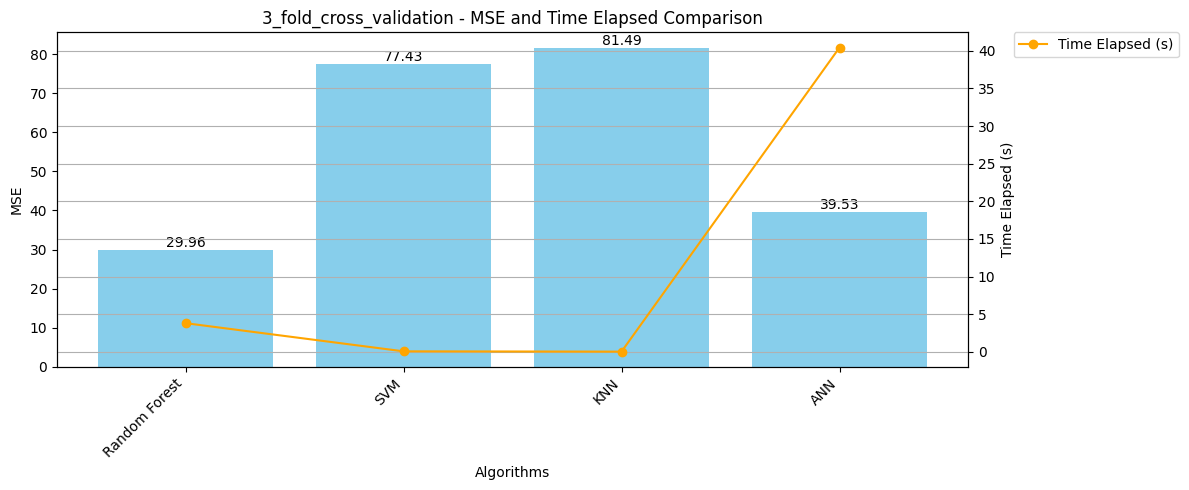

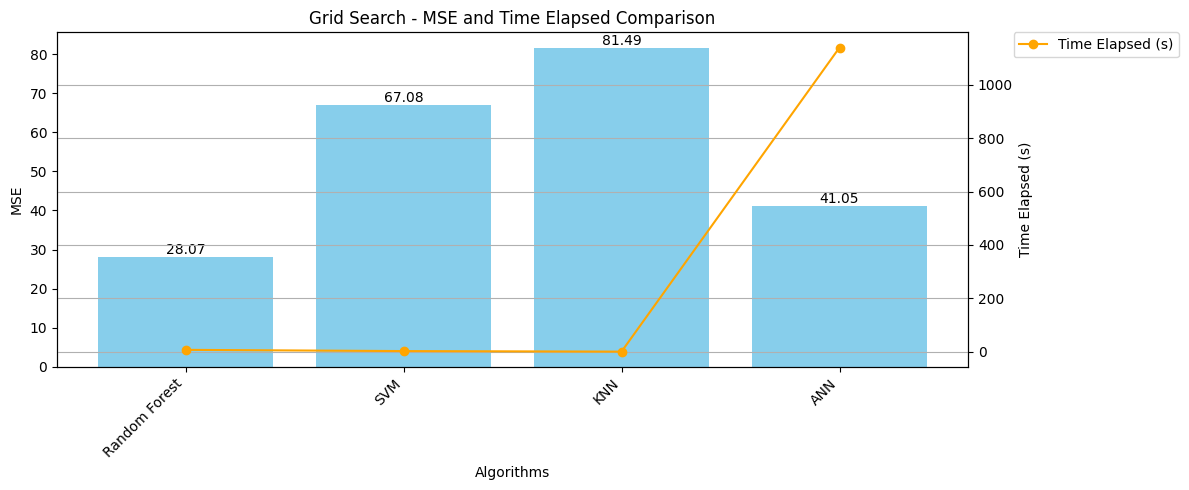

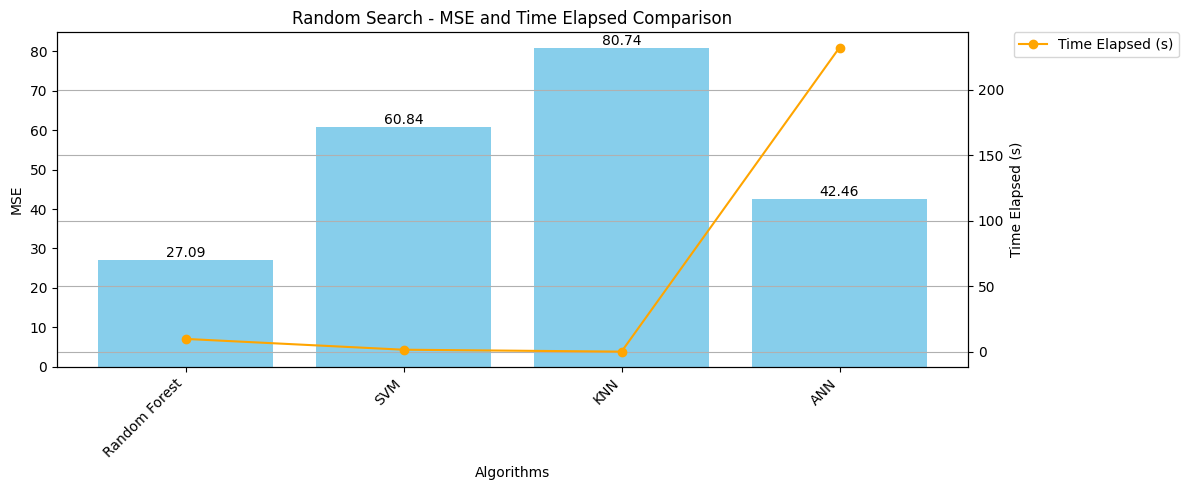

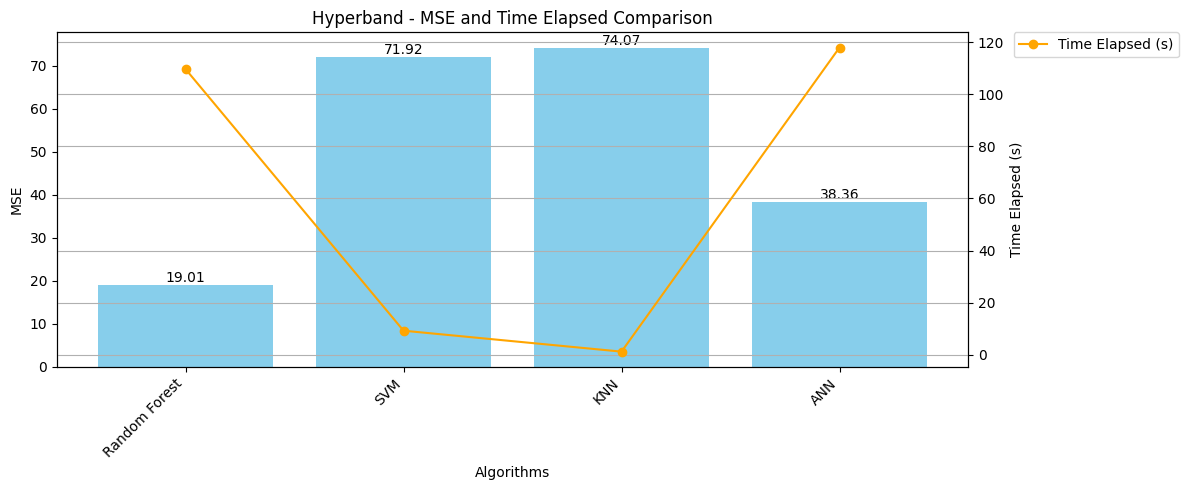

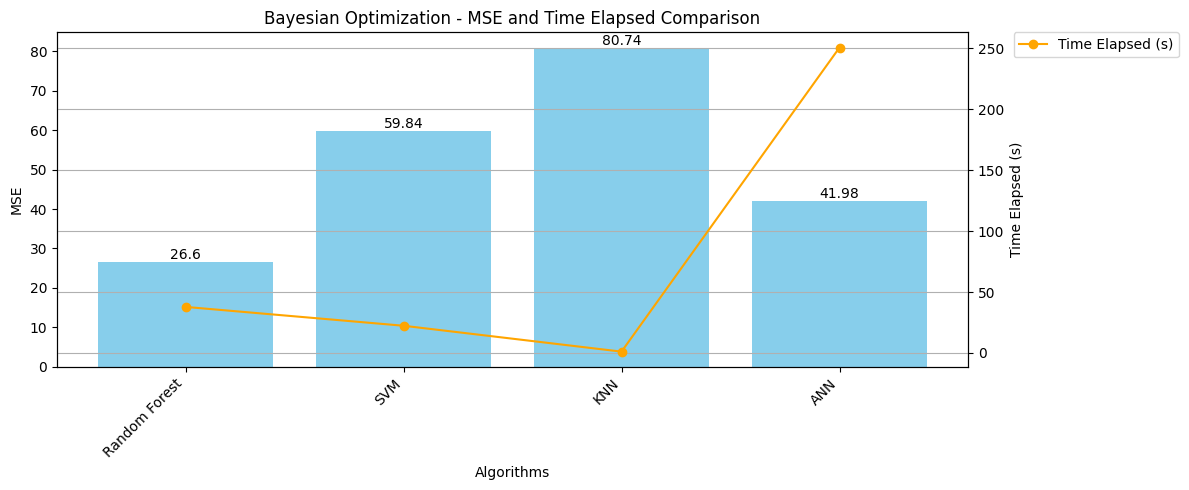

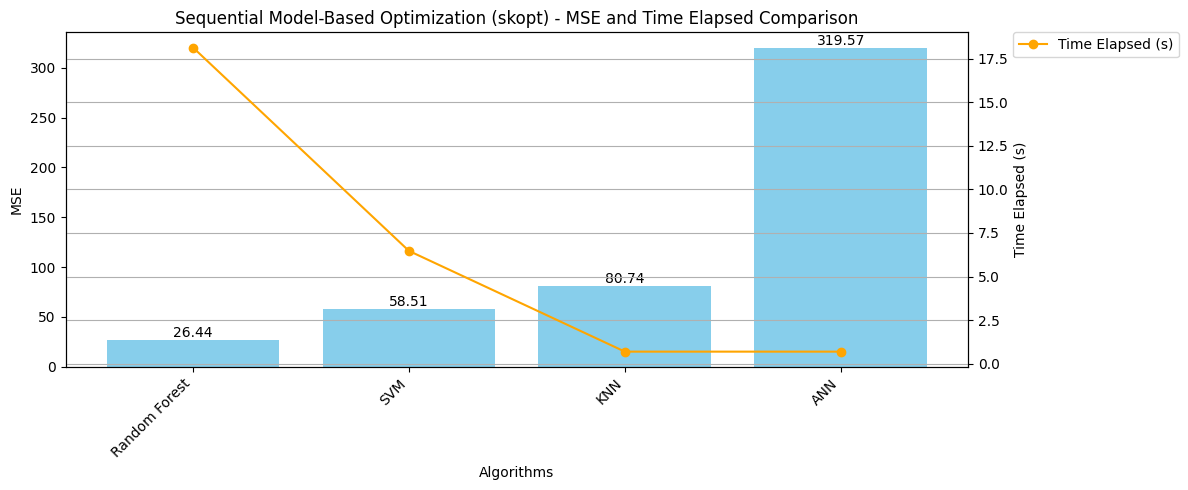

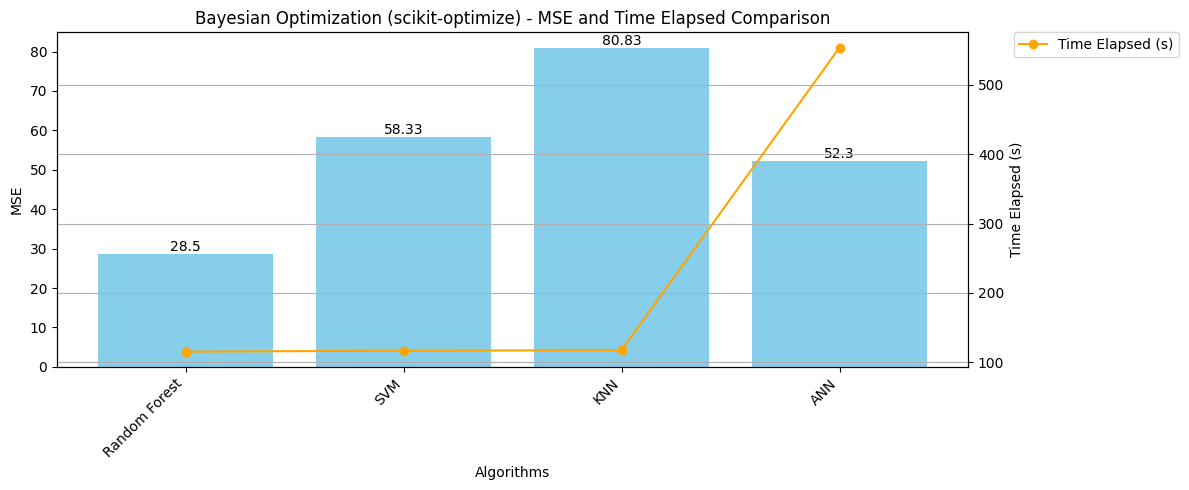

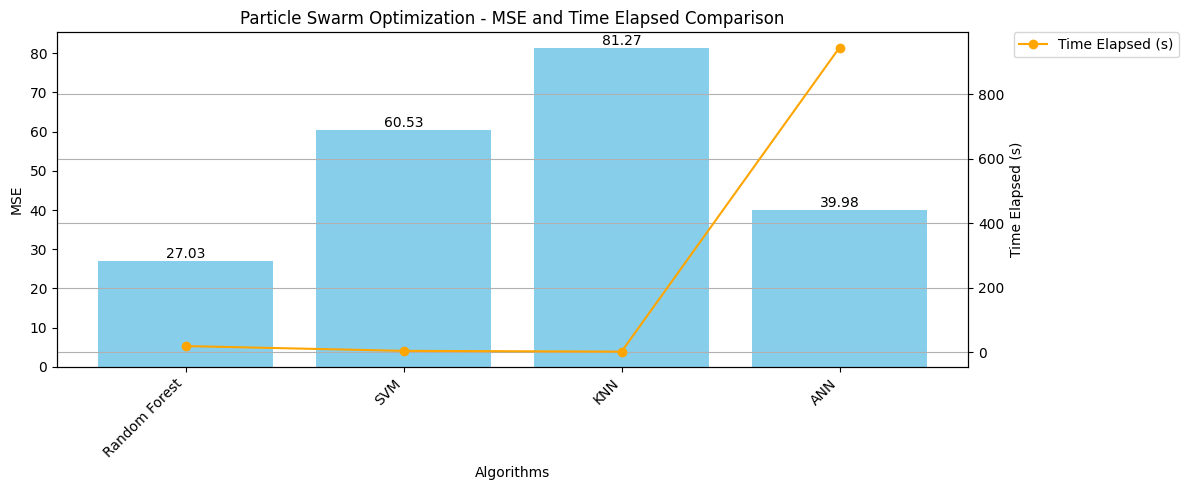

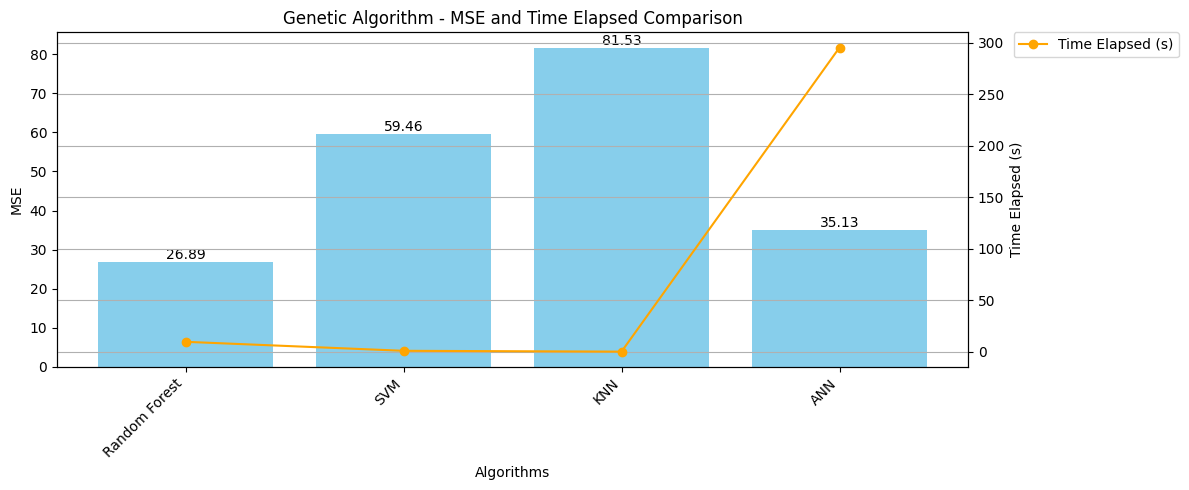

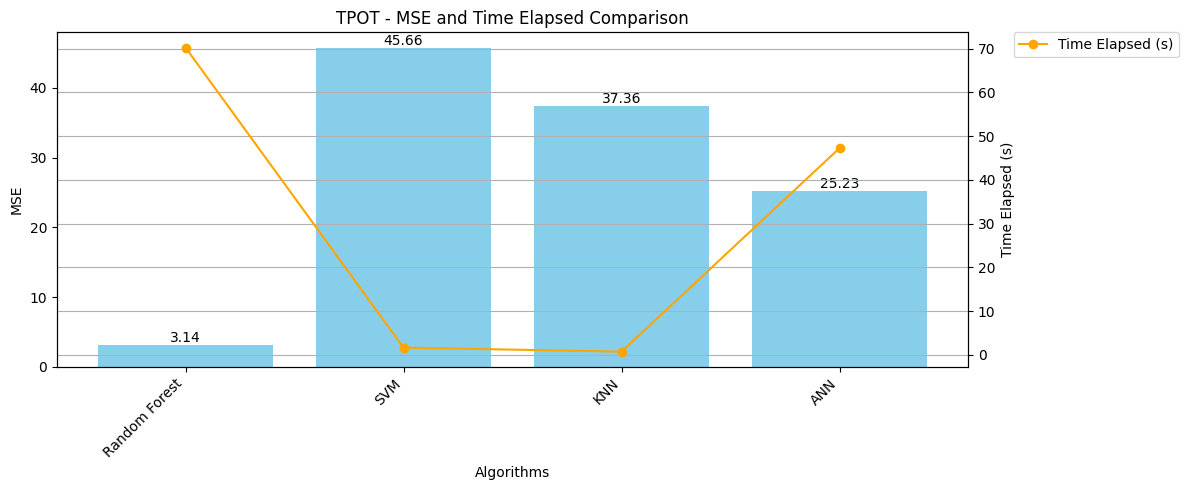

In [10]:
# Inizializza i dati per il grafico
plot_data = {}

# Popola i dati per il grafico
for procedure, results_df in all_results.items():
    plot_data[procedure] = {
        'Algorithms': results_df['Algorithm'].tolist(),
        'MSE': results_df['MSE'].tolist(),
        'Time Elapsed (s)': results_df['Time Elapsed (s)'].tolist()
    }

# Crea il grafico per ogni procedura
for procedure, data in plot_data.items():
    plt.figure(figsize=(12, 5))
    plt.title(f'{procedure} - MSE and Time Elapsed Comparison')
    bars = plt.bar(data['Algorithms'], data['MSE'], color='skyblue', label='MSE')
    plt.ylabel('MSE')
    plt.xlabel('Algorithms')
    plt.xticks(rotation=45, ha='right')

    # Aggiungi etichette per i valori sui bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.twinx()
    plt.plot(data['Algorithms'], data['Time Elapsed (s)'], marker='o', color='orange', label='Time Elapsed (s)')
    plt.ylabel('Time Elapsed (s)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
from tabulate import tabulate
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Inizializza i dati per il grafico e i vincitori
plot_data = {}
best_algorithm_mse = {}
best_algorithm_time = {}
winners_table = []
overall_winner_table = []

# Popola i dati per il grafico e determina i vincitori
for procedure, results_df in all_results.items():
    plot_data[procedure] = {
        'Algorithms': results_df['Algorithm'].tolist(),
        'MSE': results_df['MSE'].tolist(),
        'Time Elapsed (s)': results_df['Time Elapsed (s)'].tolist()
    }

    # Determina il miglior algoritmo per MSE e tempo
    best_mse_index = results_df['MSE'].idxmin()
    best_time_index = results_df['Time Elapsed (s)'].idxmin()
    best_algorithm_mse[procedure] = results_df.loc[best_mse_index, 'Algorithm']
    best_algorithm_time[procedure] = results_df.loc[best_time_index, 'Algorithm']

    # Aggiungi i vincitori alla tabella
    mse_winner = best_algorithm_mse[procedure]
    time_winner = best_algorithm_time[procedure]
    mse_value = results_df.loc[results_df['Algorithm'] == mse_winner, 'MSE'].values[0]
    time_value = results_df.loc[results_df['Algorithm'] == time_winner, 'Time Elapsed (s)'].values[0]
    winners_table.append([procedure, mse_winner, mse_value, time_winner, time_value])
    if procedure == overall_winner:
        overall_winner_table.append([procedure, mse_winner, mse_value, time_winner, time_value])

# Definisci le intestazioni delle colonne per le tabelle
headers = ["Procedure", "MSE Winner", "MSE Value", "Time Winner", "Time Elapsed (s)"]

# Specifica il percorso del file PDF in cui salvare i vincitori
pdf_file_path = "Overall_Results_first_QC.pdf"

# Crea un oggetto PdfPages per gestire il file PDF
with PdfPages(pdf_file_path) as pdf:
    # Aggiungi i grafici al PDF
    for procedure, data in plot_data.items():
        plt.figure(figsize=(12, 5))
        plt.title(f'{procedure} - MSE and Time Elapsed Comparison')
        bars = plt.bar(data['Algorithms'], data['MSE'], color='skyblue', label='MSE')
        plt.ylabel('MSE')
        plt.xlabel('Algorithms')
        plt.xticks(rotation=45, ha='right')

        # Aggiungi etichette per i valori sui bar
        for bar, mse_value in zip(bars, data['MSE']):
            plt.text(bar.get_x() + bar.get_width() / 2, mse_value, round(mse_value, 2),
                     ha='center', va='bottom', fontsize=9)

        plt.twinx()
        plt.plot(data['Algorithms'], data['Time Elapsed (s)'], marker='o', color='orange', label='Time Elapsed (s)')
        plt.ylabel('Time Elapsed (s)')
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        # Aggiungi il grafico corrente al file PDF
        pdf.savefig()
        # Chiudi la figura corrente per liberare la memoria
        plt.close()

    # Aggiungi la tabella "Best algorithm and procedure Summary"
    plt.figure(figsize=(12, 6))
    plt.text(0.5, 0.95, "Best algorithm and procedure Summary:", horizontalalignment='center', verticalalignment='top', fontsize=12, fontweight='bold')
    plt.table(cellText=winners_table, colLabels=headers, loc='center', cellLoc='center')
    plt.axis('off')
    pdf.savefig()
    plt.close()

    # Aggiungi la tabella "Overall Best algorithm and procedure"
    plt.figure(figsize=(12, 6))
    plt.text(0.5, 0.95, "Overall Best algorithm and procedure:", horizontalalignment='center', verticalalignment='top', fontsize=12, fontweight='bold')
    plt.table(cellText=overall_winner_table, colLabels=headers, loc='center', cellLoc='center')
    plt.axis('off')
    pdf.savefig()
    plt.close()

print(f"Le tabelle degli Overall Results sono state aggiunte al file PDF: {pdf_file_path}")

Le tabelle degli Overall Results sono state aggiunte al file PDF: Overall_Results_first_QC.pdf
